In [510]:
from functions import scrape_finviz, score_sentiment, update_database, update_score, get_stock_prices

import requests # for web scraping
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta
import numpy as np
import datetime
import seaborn as sns

# sentiment analysis
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize

# install yahoo finance https://aroussi.com/post/python-yahoo-finance
#!pip install yfinance
import yfinance as yf

#!pip install --user -U nltk
#nltk.download('punkt')
#nltk.download('vader_lexicon')

# install libraries for cleaning up data
from scipy.stats import boxcox
from sklearn.preprocessing import MinMaxScaler

# install libraries related to modeling
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.metrics import classification_report, accuracy_score, mean_absolute_error
from sklearn import ensemble

from scipy.stats import shapiro, pearsonr
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt 
from statsmodels.tools.eval_measures import mse, rmse

# Example of data collection workflow

In [2]:
# get S&P 500 company tickers to scrape data from
companies = pd.read_csv(r'/Users/kacikus/Dropbox/Thinkful_Data_Science_Projects/Capstone2/sp_companies.csv', header=None, names = ['tickers'])
companies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499 entries, 0 to 498
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   tickers  499 non-null    object
dtypes: object(1)
memory usage: 4.0+ KB


In [17]:
# collect new data
# for this example only scrape from Tesla and Apple
example_scrape = scrape_finviz(['TSLA','AAPL'])
# Get stock history data
example_scrape = get_stock_prices(example_scrape)
# Score the sentiment of the articles
example_scrape = score_sentiment(example_scrape)
# drop all sentiment scores of 0
example_scrape.drop(example_scrape[example_scrape['compound']==0].index, inplace = True)
# reset the index
example_scrape = example_scrape.reset_index(drop=True)
# print out column information
example_scrape.info()
# aggregate the data. Multiple articles come out for the same company on
# a single day, so get all unique results for companies/days and take mean
# sentiment score.
example_scrape.groupby(['company','date'], as_index = False).mean()

2 companies to gather data for
1
2
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 20 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   company     120 non-null    object 
 1   date        120 non-null    object 
 2   time        120 non-null    object 
 3   headline    120 non-null    object 
 4   30d         120 non-null    object 
 5   7d          120 non-null    object 
 6   prc_30d     120 non-null    object 
 7   prc_7d      120 non-null    object 
 8   std_30d     120 non-null    object 
 9   std_7d      120 non-null    object 
 10  open_price  120 non-null    object 
 11  high        120 non-null    object 
 12  low         120 non-null    object 
 13  close       120 non-null    object 
 14  volume      120 non-null    object 
 15  prc_volume  120 non-null    object 
 16  neg         120 non-null    float64
 17  neu         120 non-null    float64
 18  pos         120 non-null    float64

,company,date,neg,neu,pos,compound
0,AAPL,2020-09-03,0.198143,0.708714,0.093143,-0.164529
1,AAPL,2020-09-04,0.146022,0.708348,0.145565,0.000007
2,TSLA,2020-09-03,0.162680,0.740880,0.096480,-0.082920
3,TSLA,2020-09-04,0.129029,0.726829,0.144143,0.019786


# Data Exploration

In [367]:
# load all of the scraped data that has already been processed as shown above
df = pd.read_csv(r'/Users/kacikus/Dropbox/Thinkful_Data_Science_Projects/Capstone2/data.csv', index_col = 0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14134 entries, 0 to 14133
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   company     14134 non-null  object 
 1   date        14134 non-null  object 
 2   30d         14134 non-null  float64
 3   7d          14134 non-null  float64
 4   prc_30d     14134 non-null  float64
 5   prc_7d      14134 non-null  float64
 6   std_30d     14134 non-null  float64
 7   std_7d      14134 non-null  float64
 8   open_price  14134 non-null  float64
 9   high        14134 non-null  float64
 10  low         14134 non-null  float64
 11  close       14134 non-null  float64
 12  volume      14134 non-null  float64
 13  neg         14134 non-null  float64
 14  neu         14134 non-null  float64
 15  pos         14134 non-null  float64
 16  compound    14134 non-null  float64
 17  prc_volume  14134 non-null  float64
dtypes: float64(16), object(2)
memory usage: 2.0+ MB


In [368]:
df.head(3)

,company,date,30d,7d,prc_30d,prc_7d,std_30d,std_7d,open_price,high,low,close,volume,neg,neu,pos,compound,prc_volume
0,BEN,2020-05-19,1.46,-1.79,0.083286,-0.102111,1.096523,0.836881,18.01,18.17,17.62,17.70,3688600.0,0.1700,0.5360,0.295,0.34000,-0.242452
1,BEN,2020-05-28,2.09,0.75,0.111705,0.040086,0.622121,0.480729,19.26,19.27,18.59,18.67,3708100.0,0.1055,0.6605,0.234,0.09335,-0.246436
2,BEN,2020-05-29,1.93,1.37,0.101047,0.071728,0.600779,0.717077,18.40,18.84,18.23,18.63,7218700.0,0.2620,0.7380,0.000,-0.59940,-0.612910


In [369]:
# load in the target data
Y = pd.read_csv(r'/Users/kacikus/Dropbox/Thinkful_Data_Science_Projects/Capstone2/target.csv', index_col = 0)
Y.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14134 entries, 0 to 14133
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   1d      14134 non-null  float64
 1   1d_prc  14134 non-null  float64
dtypes: float64(2)
memory usage: 331.3 KB


In [370]:
# Create binary column for target value
# 0 will be no change or decrease in next day ('1d_prc' column)
# 1 will be increase in next day
Y['target_binary'] = np.zeros(len(Y))
Y['target_binary'].loc[Y['1d_prc'] > 0] = 1

In [371]:
# Check how many 0's and 1's there are
Y['target_binary'].value_counts()

1.0    8944
0.0    5190
Name: target_binary, dtype: int64

57% of the data points increase the next day. This is somewhat unbalanced, but for the first model we will try it and see how it goes

(0.9141492247581482, 0.0)


/Users/kacikus/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


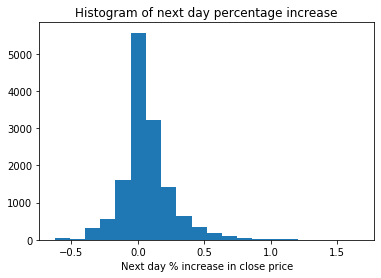

In [372]:
# check the histogram distribution of the percentage value of
# next day increase
plt.hist(Y['1d_prc'], 20) 
plt.title('Histogram of next day percentage increase')
plt.xlabel('Next day % increase in close price')
# Histogram looks normally distributed, but let's check!
print(shapiro(Y['1d_prc']))

p-value is 0, although such a large sample size may make the p-value inaccurate. We will move forward assuming the target variable is normally distributed

Text(0.5, 28.82664145601209, 'companies')

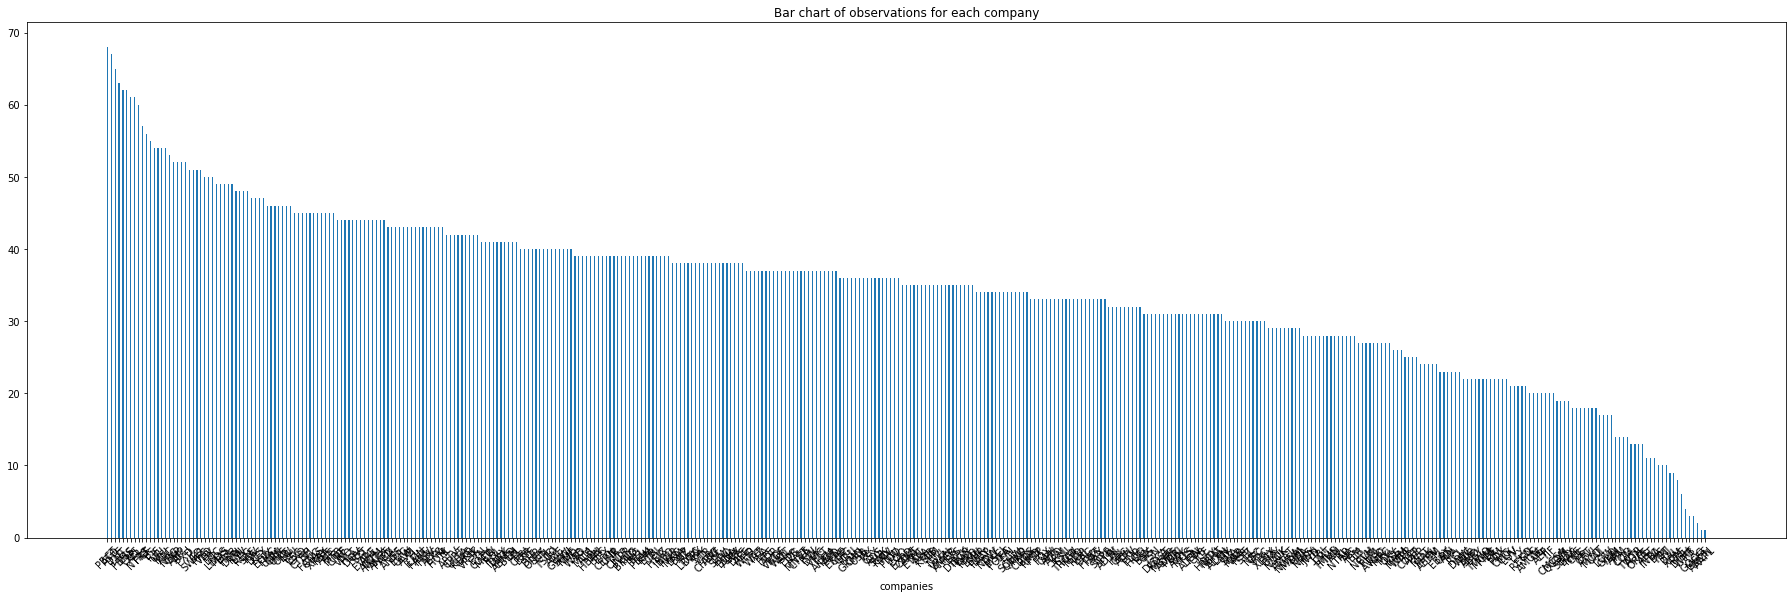

In [373]:
plt.figure(figsize= (25,8))
plt.bar(df['company'].value_counts().index, df['company'].value_counts(), width = 0.3)
plt.xticks(rotation = 45)
plt.tight_layout()
plt.title('Bar chart of observations for each company')
plt.xlabel('companies')
# no one company seems unbalanced 
# It doesn't technically matter if the companies are unbalanced, however we see that
# no one company makes up too much of the data

In [374]:
# Check if there are a mix of companies with negative target values
df['company'].loc[Y['1d_prc']<=0].value_counts()
# out of almost 500 companies, 384 of them have days where the next day closing price decreases

ATO     59
PBCT    58
ESS     51
KMI     48
MKTX    44
        ..
AMZN     1
LB       1
APD      1
PVH      1
KO       1
Name: company, Length: 384, dtype: int64

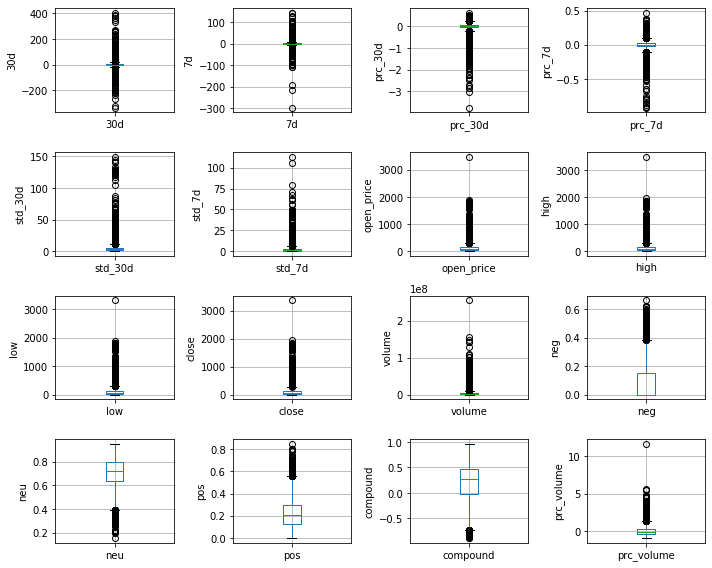

In [375]:
# Make some boxplots of the data to check for outliers
i = 1
plt.figure(figsize = (10, 8))
for var in df.columns[2:]:
    plt.subplot(4,4,i)
    df[[var]].boxplot()
    plt.ylabel(var)
    i += 1
plt.tight_layout()

In [376]:
# most of the 'outliers' are okay, but the point(s) with open prices > 2500 seem a bit too extreme
df.loc[(df['open_price']>2500) | (df['prc_volume']>10) | (df['volume']>200000000)]

,company,date,30d,7d,prc_30d,prc_7d,std_30d,std_7d,open_price,high,low,close,volume,neg,neu,pos,compound,prc_volume
1925,FTV,2019-12-24,4.32,-0.42,0.057211,-0.005562,2.056235,0.421485,76.83,77.06,75.97,76.16,270100.0,0.000000,0.842000,0.158000,0.128000,11.644613
9725,AAPL,2020-09-03,25.44,7.66,0.189596,0.057087,7.430926,3.890433,126.91,128.84,120.50,120.88,254723200.0,0.198167,0.701278,0.100556,-0.160128,0.305759
10808,AMZN,2020-09-03,387.23,57.27,0.110665,0.016367,122.069228,40.835328,3485.00,3488.41,3303.00,3368.00,8114400.0,0.116857,0.673071,0.210107,0.121596,0.065882


In [377]:
# just a few data points, so we will remove them
# index values are 1925, 1725, 10808
df.drop([1925, 9725, 10808], inplace = True)
Y.drop([1925, 9725, 10808], inplace = True)
df = df.reset_index(drop = True)
Y = Y.reset_index(drop = True)

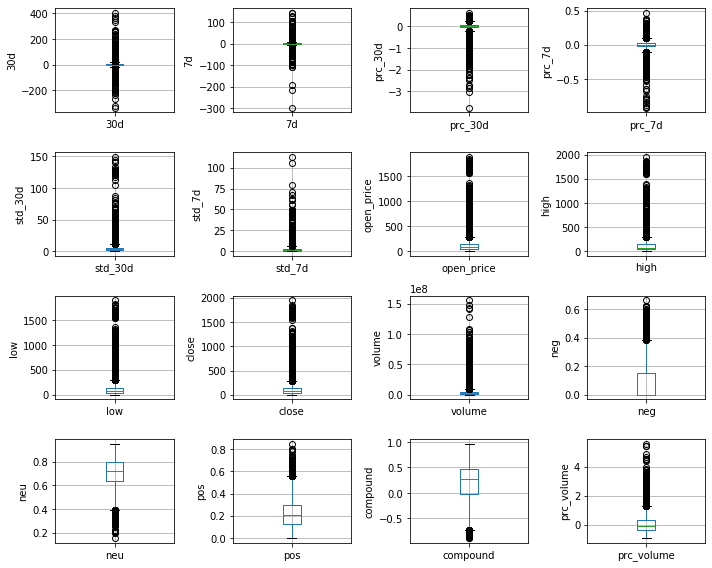

In [378]:
# check box plots again
i = 1
plt.figure(figsize = (10, 8))
for var in df.columns[2:]:
    plt.subplot(4,4,i)
    df[[var]].boxplot()
    plt.ylabel(var)
    i += 1
plt.tight_layout()
# all outliers have been handled

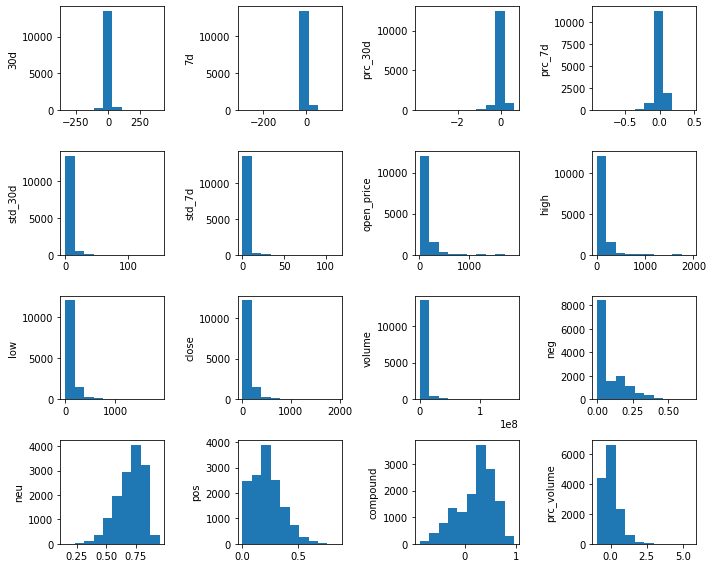

In [379]:
# Make some histograms of the data to check for normality
i = 1
plt.figure(figsize = (10, 8))
for var in df.columns[2:]:
    plt.subplot(4,4,i)
    plt.hist(df[var])
    plt.ylabel(var)
    i += 1
plt.tight_layout()

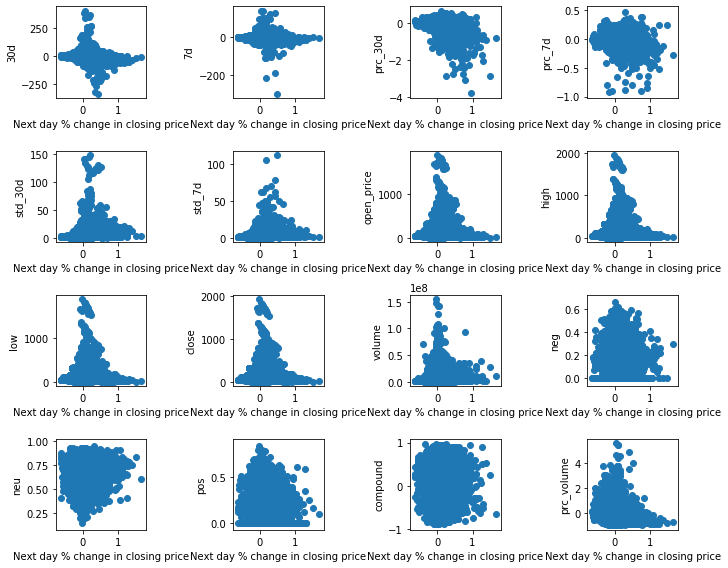

In [380]:
# Make some scatter plots 
i = 1
plt.figure(figsize = (10, 8))
for var in df.columns[2:]:
    plt.subplot(4,4,i)
    plt.scatter(Y['1d_prc'], df[var])
    plt.ylabel(var)
    plt.xlabel('Next day % change in closing price')
    i += 1
plt.tight_layout()

In [381]:
# create binary column for increase (1)/decrease (0) from previous 30 and 7 days
df['7d_binary'] = np.zeros(len(df))
df['7d_binary'][df[df['7d'] > 0].index] = 1

df['30d_binary'] = np.zeros(len(df))
df['30d_binary'][df[df['30d'] > 0].index] = 1

df.head(2)

/Users/kacikus/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/kacikus/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,company,date,30d,7d,prc_30d,prc_7d,std_30d,std_7d,open_price,high,low,close,volume,neg,neu,pos,compound,prc_volume,7d_binary,30d_binary
0,BEN,2020-05-19,1.46,-1.79,0.083286,-0.102111,1.096523,0.836881,18.01,18.17,17.62,17.70,3688600.0,0.1700,0.5360,0.295,0.34000,-0.242452,0.0,1.0
1,BEN,2020-05-28,2.09,0.75,0.111705,0.040086,0.622121,0.480729,19.26,19.27,18.59,18.67,3708100.0,0.1055,0.6605,0.234,0.09335,-0.246436,1.0,1.0


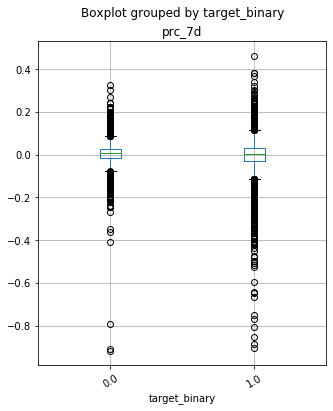

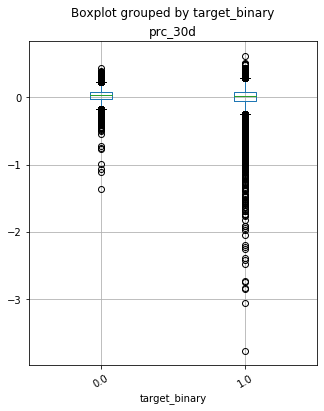

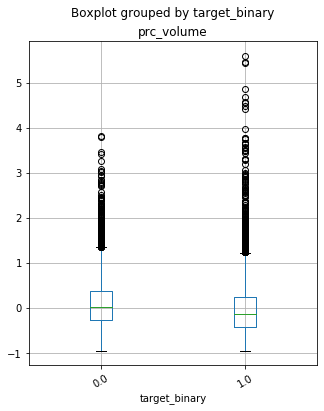

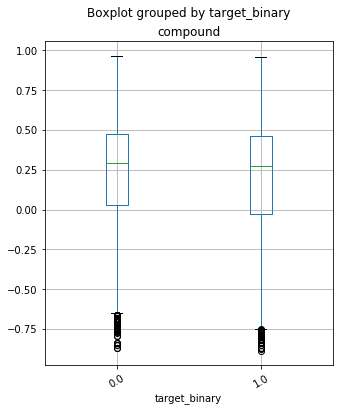

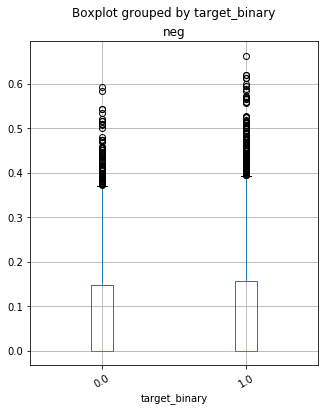

In [581]:
# some boxplots to compare feature distributions by target
# % change from previous 7 days
pd.concat([df, Y], axis = 1).boxplot('prc_7d','target_binary',rot = 30,figsize=(5,6))
# % change from previous 30 days
pd.concat([df, Y], axis = 1).boxplot('prc_30d','target_binary',rot = 30,figsize=(5,6))
# % change in volume from previous 30 days
pd.concat([df, Y], axis = 1).boxplot('prc_volume','target_binary',rot = 30,figsize=(5,6))
# Compound score
pd.concat([df, Y], axis = 1).boxplot('compound','target_binary',rot = 30,figsize=(5,6))
# Compound score
pd.concat([df, Y], axis = 1).boxplot('neg','target_binary',rot = 30,figsize=(5,6))

* In general. Target values == 1 (meaning next day closing price increased) have a slightly larger range of values for features such as the prc_7d (percent change over previous 7 days), and prc_30d (percent change over previous 30 days)

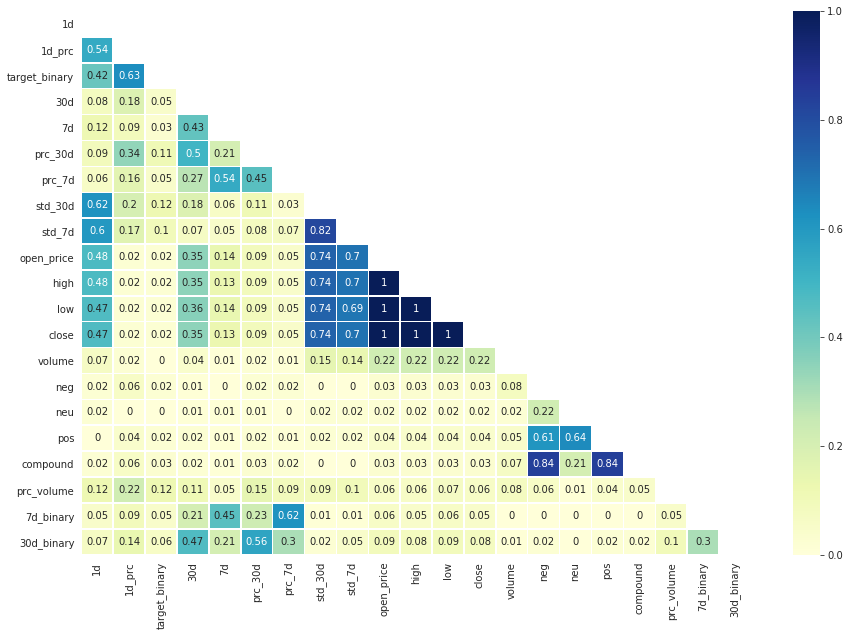

In [382]:
# plot correlation matrix
corr = abs(pd.concat([Y,df], axis=1).corr().round(2))
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style('white'):
    plt.figure(figsize=(15,10))
    sns.heatmap(corr, cmap="YlGnBu", mask = mask, linewidths=0.5, annot=True)
# make another column that says either positive or negative icnrease over 30 days
# check if there is an incerase over 30 days if that correlates with the target increasing

# data augmentation

From the correlation matrix it appears that none of the features are especially highly correlated with the target, so that's good! 

However, there are some high correlation coefficients between the features themselves. Here we will consider anything above 0.7 too high.

* std_30d is highly correlated with std_7d, close, low, high, and open price. Because std_30d is more highly correlated with the target, we will drop std_7d.
* open_price, high, low, and close are all VERY strongly correlated... instead of completely dropping them, I will try to create a new feature to represent the degree of variance for the day before the target.
* neg and pos are also strongly correlated with compound, which makes sense because they contribute to calculating compound sentiment score. We will drop neg and pos, but keep neu (neutral) for now.

Before doing any feature engineering though, I will run a logistic regression model with all of the parameters.

# Base Logistic Regression Model

In [582]:
# import libraries
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# make dataframe for features
X = df[['30d', '7d', 'prc_30d', 'prc_7d', 'std_30d',
       'std_7d', 'open_price', 'high', 'low', 'close', 'volume', 'neg', 'neu',
       'pos', 'compound', 'prc_volume','7d_binary','30d_binary']]
y = Y['target_binary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2)

lr_model = LogisticRegression(solver = 'lbfgs',random_state = 2)
lr_model.fit(X_train, y_train)

print('accuracy score is: {}'.format(round(lr_model.score(X_test, y_test),2)))
print('{} of total observations result in increase the next day'.format(round(y_test.value_counts()[1]/len(y_test),2)))


accuracy score is: 0.62
0.62 of total observations result in increase the next day


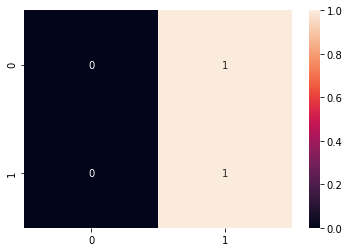

In [583]:
# check confusion matrix
y_pred = lr_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred, normalize = 'true')
sns.heatmap(cm, annot = True)

In [584]:
pd.Series(y_pred).value_counts()

1.0    4240
dtype: int64

The results of the simple logistic regression model are pretty bad. It shows that it is finding NONE of the true negatives, and seems to just be assigning everything to be 1, which represents an increase in the next day.

## Base model that contains all parameters

In [593]:
def find_parameters(X_train, y_train):
    # Initialize and fit the model.
    model = ensemble.GradientBoostingClassifier()
    clf.fit(X_train, y_train)

    # set weak tree parameters
    parameters = {'learning_rate': [0.01, 0.1, 0.25],
                  'subsample'    : [0.1, 0.4, 0.7],
                  'n_estimators' : [500],
                  'max_depth'    : [9]
                 }
    randm = GridSearchCV(estimator=model, param_grid = parameters,
                              cv = 3, n_jobs = -1)
    randm.fit(X_train, y_train)

    print("\n The best score across ALL searched params:\n",
          randm.best_score_)

    print("\n The best parameters across ALL searched params:\n",
          randm.best_params_)

    print("\n ========================================================")
    return

find_parameters(X_train, y_train)


 The best score across ALL searched params:
 0.7152967344050146

 The best parameters across ALL searched params:
 {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 500, 'subsample': 0.7}



#### Note these values are from a previous random search! But the method to find them is as above
So by using parameters of:
* learning rate: 0.1
* max depth: 9
* n_estimators: 741
* subsample: 0.7

The best accuracy score is 0.71. 

Therefore, in order to increase the accuracy maybe we can mess around with the features a little instead...

In [594]:
# make dataframe for features
X = df[['30d', '7d', 'prc_30d', 'prc_7d', 'std_30d',
       'std_7d', 'open_price', 'high', 'low', 'close', 'volume', 'neg', 'neu',
       'pos', 'compound', 'prc_volume','7d_binary','30d_binary']]
y = Y['target_binary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2)

# set weak tree parameters to that output above
params = {'n_estimators': 741,
          'learning_rate': 0.1,
          'max_depth': 9,
          'loss': 'deviance',
          'subsample': 0.7}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params, random_state = 0)
clf.fit(X_train, y_train)

# predict results using traning vs test data
predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

# accuracy
print('accuracy is: {}'.format(clf.score(X_test, y_test)))
y_pred = clf.predict(X_test)
print('precision is: {}'.format(precision_score(y_test,y_pred)))
print('recall_score is: {}'.format(recall_score(y_test,y_pred)))

# accuracy of the base gradient boosting classifier model is slightly better, 
# but still suffers from choosing too many false positives

accuracy is: 0.7257075471698113
precision is: 0.7360178970917226
recall_score is: 0.8723484848484848


In [596]:
cross_val_score(clf, X, y, cv=5)

array([0.6204457 , 0.56864827, 0.63092711, 0.64543524, 0.62101911])

* Cross validation shows scores ranging from 0.56 to 0.64

[ 0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5 13.5
 14.5 15.5 16.5 17.5]


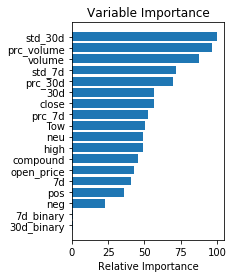

In [597]:
def get_feature_importance(clf):
    feature_importance = clf.feature_importances_
    # Make importances relative to max importance.
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5
    print(pos)
    plt.subplot(1, 2, 2)
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, X.columns[sorted_idx])
    plt.xlabel('Relative Importance')
    plt.title('Variable Importance')
    plt.show()
    return
get_feature_importance(clf)

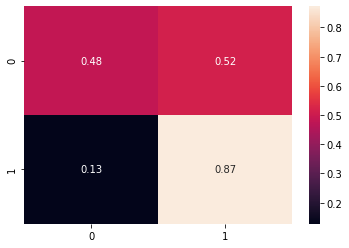

In [598]:
# confusion matrix 
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred, normalize = 'true')
sns.heatmap(cm, annot = True)

* Gradient boosting model improved accuracy from 0.62 using logistic regression, which simply represented the accuracy of random guesses, to 0.73.
* From the confusion matrix we see that the number of false positives has also significantly decreased from 100% to 52%

# Attempt to improve model's identification of true negatives and reduce false positives

## Feature engineering

In [599]:
# Remove neg, pos, and 7d_std.
df_v2 = df.drop(['neg','pos','std_7d'], axis = 1)

# try to combine open_price, high, low, and close into a new feature
# calculate ratio of open price to close price
df_v2['open/close'] = df['open_price']/df['close']

# lets also calculate the range of the low to the high price as a fraction of the close price
df_v2['range'] = ((df['high'] - df['low'])/df['close']) * 100

# drop open_price, close, high, and low columns. 
# also drop company
df_v2.drop(['open_price','high','low','close','company'], axis = 1, inplace = True)

# transform day of week into categorical, and make dummies
df_v2['day'] = pd.to_datetime(df['date']).dt.weekday
# note monday == 0, Sunday == 6
# for legibility of dummies, convert numerical days to strings
df_v2['day'].loc[df_v2['day'] == 0] = 'monday'
df_v2['day'].loc[df_v2['day'] == 1] = 'tuesday'
df_v2['day'].loc[df_v2['day'] == 2] = 'wednesday'
df_v2['day'].loc[df_v2['day'] == 3] = 'thursday'
df_v2['day'].loc[df_v2['day'] == 4] = 'friday'
df_v2['day'].loc[df_v2['day'] == 5] = 'saturday'
df_v2['day'].loc[df_v2['day'] == 6] = 'sunday'

# check distribution of days of week
print(df_v2['day'].value_counts()) # seems pretty evenly distributed!

# create dummies
df_v2 = pd.get_dummies(df_v2, columns = ['day'], drop_first = True)
# drop date column
df_v2.drop(['date'], axis = 1, inplace = True)

thursday     3077
wednesday    3010
tuesday      2871
monday       2686
friday       2487
Name: day, dtype: int64


/Users/kacikus/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [600]:
df_v2.info() # check dataframe looks okay
print(df_v2.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14131 entries, 0 to 14130
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   30d            14131 non-null  float64
 1   7d             14131 non-null  float64
 2   prc_30d        14131 non-null  float64
 3   prc_7d         14131 non-null  float64
 4   std_30d        14131 non-null  float64
 5   volume         14131 non-null  float64
 6   neu            14131 non-null  float64
 7   compound       14131 non-null  float64
 8   prc_volume     14131 non-null  float64
 9   7d_binary      14131 non-null  float64
 10  30d_binary     14131 non-null  float64
 11  open/close     14131 non-null  float64
 12  range          14131 non-null  float64
 13  day_monday     14131 non-null  uint8  
 14  day_thursday   14131 non-null  uint8  
 15  day_tuesday    14131 non-null  uint8  
 16  day_wednesday  14131 non-null  uint8  
dtypes: float64(13), uint8(4)
memory usage: 1.5 MB
Inde

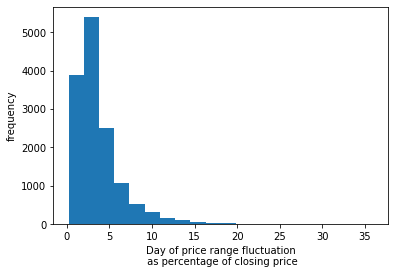

<Figure size 720x576 with 0 Axes>

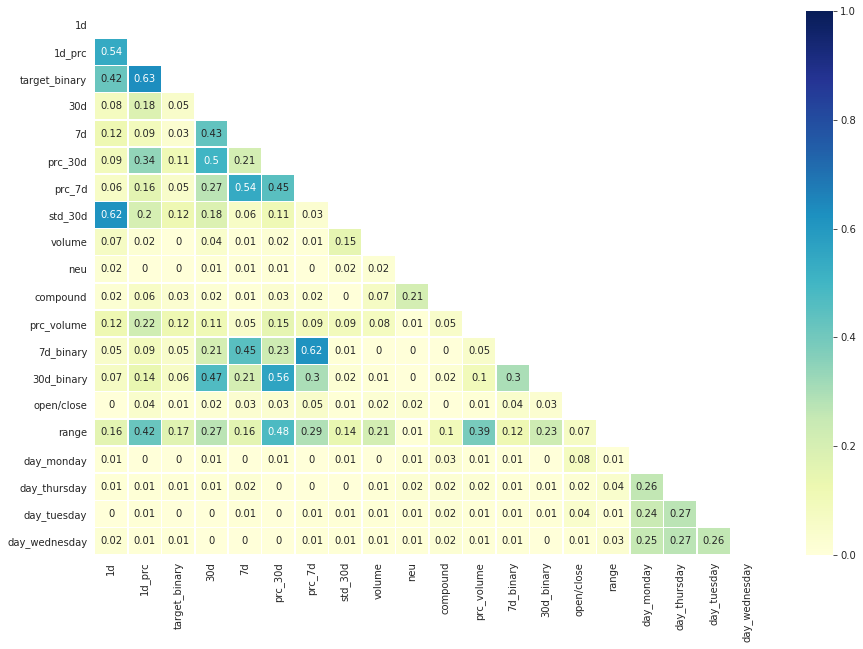

In [601]:
# Check what range of the daily range is like to see if maybe we can divide into categorical
plt.hist(df_v2['range'],20) # most stocks fluctuate between 0 and 25% of their close price
plt.xlabel('Day of price range fluctuation\n as percentage of closing price')
plt.ylabel('frequency')

plt.figure(figsize=(10,8))
corr = abs(pd.concat([Y,df_v2], axis=1).corr().round(2))
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style('white'):
    plt.figure(figsize=(15,10))
    sns.heatmap(corr, cmap="YlGnBu", mask = mask, linewidths=0.5, annot=True)

The newly added range and open/close features are not too strongly correlated with anything else.
We have also successfully gotten rid of features that were too strongly correlated with one another.

In [602]:
Y['target_binary'].value_counts()

1.0    8943
0.0    5188
Name: target_binary, dtype: int64

The previous model preformed poorly for targets equal to 0, I suspect because of how unbalanced the dataset is. To try and fix this, I will re-sample the 0's to increase the number of data points from 5188 to 8943 so both target values are equally represented.

* by sampling with replacement some data points will be duplicated

In [607]:
# Combine features and target data together so we can try sub-sampling the positive values to try and better
# estimate the targets == 0 (decrease/no change) since that is what is being over-estimated.
data = pd.concat([df_v2[['30d', '7d', 'prc_30d', 'prc_7d', 'std_30d', 'volume', 'neu',
                         'compound', 'prc_volume', '7d_binary', '30d_binary', 'open/close',
                         'range', 'day_monday', 'day_thursday', 'day_tuesday', 'day_wednesday']], Y], axis = 1)
df_0 = data.loc[data['target_binary'] == 0]
df_1 = data.loc[data['target_binary'] == 1]

data = pd.concat([df_0.sample(n = 8943, random_state = 2, replace = True), df_1], axis = 0).reset_index(drop = True)


In [609]:
# check to make sure target values are equally balanced
data['target_binary'].value_counts() 

1.0    8943
0.0    8943
Name: target_binary, dtype: int64

# Gradient boosting model

In [615]:
# assign features and target for modeling
X = data[['30d', '7d', 'prc_30d', 'prc_7d', 'std_30d', 'volume', 'neu',
          'compound', 'prc_volume', '7d_binary', '30d_binary', 'open/close',
          'range', 'day_monday', 'day_thursday', 'day_tuesday', 'day_wednesday']]
y = data['target_binary']

# create training and test sets with 20% of data in the test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

# scale just the training data set
scaler = MinMaxScaler(feature_range = (0,1))
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train),
                       columns = ['30d', '7d', 'prc_30d', 'prc_7d', 'std_30d', 'volume', 'neu',
                                  'compound', 'prc_volume', '7d_binary', '30d_binary', 'open/close',
                                  'range', 'day_monday', 'day_thursday', 'day_tuesday', 'day_wednesday'])
X_test = pd.DataFrame(scaler.transform(X_test),
                       columns = ['30d', '7d', 'prc_30d', 'prc_7d', 'std_30d', 'volume', 'neu',
                                  'compound', 'prc_volume', '7d_binary', '30d_binary', 'open/close',
                                  'range', 'day_monday', 'day_thursday', 'day_tuesday', 'day_wednesday'])

In [619]:
# set weak tree parameters
params = {'n_estimators': 741,
          'learning_rate': 0.1,
          'max_depth': 9,
          'loss': 'deviance',
          'subsample': 0.7}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params, random_state = 2)
clf.fit(X_train, y_train)

# predict results using traning vs test data
predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

# accuracy
print('accuracy is: {}'.format(clf.score(X_test, y_test)))
y_pred = clf.predict(X_test)
print('precision is: {}'.format(precision_score(y_test,y_pred)))
print('recall_score is: {}'.format(recall_score(y_test,y_pred)))

clf_scaled = classification_report(y_test, y_pred)

accuracy is: 0.8440469536053661
precision is: 0.8585915492957746
recall_score is: 0.8323320589841616


In [620]:
print(clf_scaled)

              precision    recall  f1-score   support

         0.0       0.83      0.86      0.84      1747
         1.0       0.86      0.83      0.85      1831

    accuracy                           0.84      3578
   macro avg       0.84      0.84      0.84      3578
weighted avg       0.84      0.84      0.84      3578



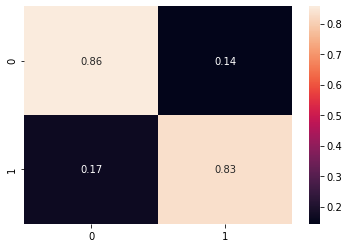

In [621]:
# Check confusion matrix again
# add random seed
cm = confusion_matrix(y_test, y_pred, normalize = 'true')
sns.heatmap(cm, annot = True)

Wow! By balancing the target values and scaling the features, the accuracy improved from 0.72 to 0.84.
* The false positive rate also decreased again from 0.52 to 0.14, which is a major improvement!
* There is also a good false negative rate as well: 0.17.

[ 0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5 13.5
 14.5 15.5 16.5]


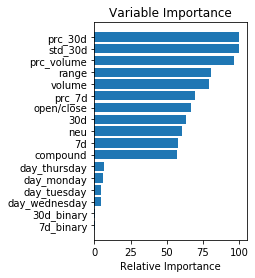

In [622]:
get_feature_importance(clf)

## Check to see if taking away the sentiment analysis features affects the results

accuracy is: 0.8415315818893236
precision is: 0.8590909090909091
recall_score is: 0.8257782632441288


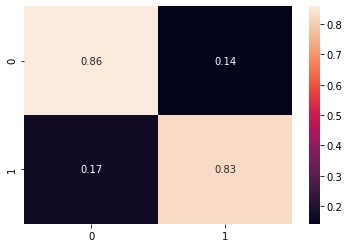

In [660]:
# assign features and target for modeling
X = data[['30d', '7d', 'prc_30d', 'prc_7d', 'std_30d', 'volume',
          'prc_volume', '7d_binary', '30d_binary', 'open/close',
          'range', 'day_monday', 'day_thursday', 'day_tuesday', 'day_wednesday']]
y = data['target_binary']

# create training and test sets with 20% of data in the test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

# scale just the training data set
scaler = MinMaxScaler(feature_range = (0,1))
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train),
                       columns = ['30d', '7d', 'prc_30d', 'prc_7d', 'std_30d', 'volume',
                                  'prc_volume', '7d_binary', '30d_binary', 'open/close',
                                  'range', 'day_monday', 'day_thursday', 'day_tuesday', 'day_wednesday'])
X_test = pd.DataFrame(scaler.transform(X_test),
                       columns = ['30d', '7d', 'prc_30d', 'prc_7d', 'std_30d', 'volume',
                                  'prc_volume', '7d_binary', '30d_binary', 'open/close',
                                  'range', 'day_monday', 'day_thursday', 'day_tuesday', 'day_wednesday'])

# set weak tree parameters
params = {'n_estimators': 741,
          'learning_rate': 0.1,
          'max_depth': 9,
          'loss': 'deviance',
          'subsample': 0.7}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params, random_state = 2)
clf.fit(X_train, y_train)

# predict results using traning vs test data
predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

# accuracy
print('accuracy is: {}'.format(clf.score(X_test, y_test)))
y_pred = clf.predict(X_test)
print('precision is: {}'.format(precision_score(y_test,y_pred)))
print('recall_score is: {}'.format(recall_score(y_test,y_pred)))

clf_scaled = classification_report(y_test, y_pred)

# Check confusion matrix again
# add random seed
cm = confusion_matrix(y_test, y_pred, normalize = 'true')
sns.heatmap(cm, annot = True)

Honestly it seems that the sentiment analysis compound score has very little to no affect on the final model results! However, it also does not seem to be harming the results so we will continue to keep it in the next models.

Sentiment analysis is currently using the default nltk dictionary and scores, which was designed for social media use but not specifically for financial/stock analysis. Therefore, if we updated the dictionary in the future it may have a more profound affect on our results.

# Try support vector machines model for classification

In [629]:
# import library for svm
from sklearn import svm
from sklearn.model_selection import GridSearchCV

# create function to do grid search of parameters for SVC model
def svc_param_selection(X, y, nfolds):
    Cs = [0.001, 0.01, 0.1, 1, 10]
    gammas = [0.001, 0.01, 0.1, 1]
    kernels = ['linear','rbf']
    param_grid = {'C': Cs, 'gamma' : gammas, 'kernel' : kernels}
    grid_search = GridSearchCV(svm.SVC(kernel='rbf'), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

# assign features and target for modeling
X = data[['30d', '7d', 'prc_30d', 'prc_7d', 'std_30d', 'volume', 'neu',
          'compound', 'prc_volume', '7d_binary', '30d_binary', 'open/close',
          'range', 'day_monday', 'day_thursday', 'day_tuesday', 'day_wednesday']]
y = data['target_binary']

# create training and test sets with 40% of data in the test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=2)

# scale just the training data set
scaler = MinMaxScaler(feature_range = (0,1))
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train),
                       columns = ['30d', '7d', 'prc_30d', 'prc_7d', 'std_30d', 'volume', 'neu',
                                  'compound', 'prc_volume', '7d_binary', '30d_binary', 'open/close',
                                  'range', 'day_monday', 'day_thursday', 'day_tuesday', 'day_wednesday'])
X_test = pd.DataFrame(scaler.transform(X_test),
                       columns = ['30d', '7d', 'prc_30d', 'prc_7d', 'std_30d', 'volume', 'neu',
                                  'compound', 'prc_volume', '7d_binary', '30d_binary', 'open/close',
                                  'range', 'day_monday', 'day_thursday', 'day_tuesday', 'day_wednesday'])

#svc_param_selection(X_train, y_train, 5)

Used grid search for param selection and got:
* C = 10
* gamma = 1
* kernel = 'rbf'

In [631]:
svm = svm.SVC(C = 10, gamma = 1, kernel = 'rbf', random_state = 2)
svm.fit(X_train, y_train)
# accuracy
print('accuracy is: {}'.format(svm.score(X_test, y_test)))
y_pred = svm.predict(X_test)
print('precision is: {}'.format(precision_score(y_test,y_pred)))
print('recall_score is: {}'.format(recall_score(y_test,y_pred)))

accuracy is: 0.5984626135569532
precision is: 0.6575993091537133
recall_score is: 0.42270330280321955


In [635]:
svm_scaled = classification_report(y_test, y_pred)
svm_scaled

'              precision    recall  f1-score   support\n\n         0.0       0.57      0.78      0.66      3552\n         1.0       0.66      0.42      0.51      3603\n\n    accuracy                           0.60      7155\n   macro avg       0.61      0.60      0.59      7155\nweighted avg       0.61      0.60      0.59      7155\n'

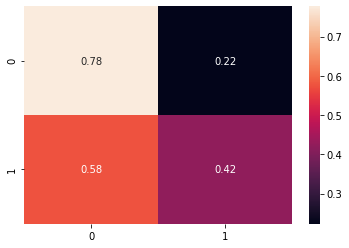

In [636]:
# Check confusion matrix again
cm = confusion_matrix(y_test, y_pred, normalize = 'true')
sns.heatmap(cm, annot = True)

The SVC model overall does not preform as well as the gradient boosted model, but it is better than the simple logistic regression model.
* Accuracy is 0.6
* False positive score is 0.22, wheareas gradient boosted model had a false positive rate of 0.14

# Random Forest Classifier

In [637]:
# import random forest library
from sklearn.ensemble import RandomForestClassifier

def forest_param_selection(X, y):
    n_estimators = [100, 150, 200, 250, 300, 350]
    criterion = ['gini','entropy']
    max_depth = np.arange(1,17,1)
    min_samples_split = np.arange(2,40,2)
    
    rfc = RandomForestClassifier()
    
    param_grid = {'n_estimators': n_estimators, 
                  'criterion' : criterion, 
                  'max_depth' : max_depth,
                  'min_samples_split' : min_samples_split}
    grid_search = GridSearchCV(estimator = rfc, param_grid = param_grid, cv=5)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

# assign features and target for modeling
X = data[['30d', '7d', 'prc_30d', 'prc_7d', 'std_30d', 'volume', 'neu',
          'compound', 'prc_volume', '7d_binary', '30d_binary', 'open/close',
          'range', 'day_monday', 'day_thursday', 'day_tuesday', 'day_wednesday']]
y = data['target_binary']

# create training and test sets with 40% of data in the test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=2)

# scale just the training data set
scaler = MinMaxScaler(feature_range = (0,1))
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train),
                       columns = ['30d', '7d', 'prc_30d', 'prc_7d', 'std_30d', 'volume', 'neu',
                                  'compound', 'prc_volume', '7d_binary', '30d_binary', 'open/close',
                                  'range', 'day_monday', 'day_thursday', 'day_tuesday', 'day_wednesday'])
X_test = pd.DataFrame(scaler.transform(X_test),
                       columns = ['30d', '7d', 'prc_30d', 'prc_7d', 'std_30d', 'volume', 'neu',
                                  'compound', 'prc_volume', '7d_binary', '30d_binary', 'open/close',
                                  'range', 'day_monday', 'day_thursday', 'day_tuesday', 'day_wednesday'])


#forest_param_selection(X_train, y_train)

Random forest param selection results:
* criterion: 'gini'
* max depth: 15
* min_samples_split: 10
* n_estimators: 300

In [639]:
rfc = RandomForestClassifier(n_estimators = 300,
                            criterion = 'gini',
                            max_depth = 15,
                            min_samples_split = 10,
                            random_state = 2)
rfc.fit(X_train, y_train)

# accuracy
print('accuracy is: {}'.format(rfc.score(X_test, y_test)))
y_pred = rfc.predict(X_test)
print('precision is: {}'.format(precision_score(y_test,y_pred)))
print('recall_score is: {}'.format(recall_score(y_test,y_pred)))

rfc_scaled = classification_report(y_test, y_pred)

accuracy is: 0.756953179594689
precision is: 0.8104596935376416
recall_score is: 0.675270607826811


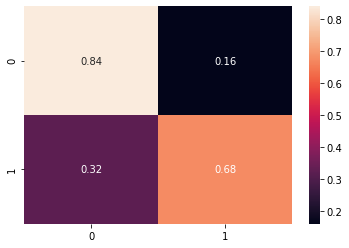

In [641]:
# Check confusion matrix again
cm = confusion_matrix(y_test, y_pred, normalize = 'true')
sns.heatmap(cm, annot = True)

The Random Forest Classifier has an accuracy of 0.75, which is better than the support vector machine model, but still not quite as good as the gradient boosted model.
* false positive score is relatively low, which is good
* false negative score is not as low as the gradient boosted model.

# Try KNN model

The challenge is to choose the best number of n_neighbors. If n is too small, then there will be over-fitting, but if n is too large, then it will underfit and be computationally expensive.

Here we will use k = sqrt(n), where n is the number of samples in the training dataset.

Here, n = 10730, so k will be rounded to 105.

In [656]:
# assign features and target for modeling
X = data[['30d', '7d', 'prc_30d', 'prc_7d', 'std_30d', 'volume', 'neu',
          'compound', 'prc_volume', '7d_binary', '30d_binary', 'open/close',
          'range', 'day_monday', 'day_thursday', 'day_tuesday', 'day_wednesday']]
y = data['target_binary']

# create training and test sets with 40% of data in the test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=2)

# scale just the training data set
scaler = MinMaxScaler(feature_range = (0,1))
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train),
                       columns = ['30d', '7d', 'prc_30d', 'prc_7d', 'std_30d', 'volume', 'neu',
                                  'compound', 'prc_volume', '7d_binary', '30d_binary', 'open/close',
                                  'range', 'day_monday', 'day_thursday', 'day_tuesday', 'day_wednesday'])
X_test = pd.DataFrame(scaler.transform(X_test),
                       columns = ['30d', '7d', 'prc_30d', 'prc_7d', 'std_30d', 'volume', 'neu',
                                  'compound', 'prc_volume', '7d_binary', '30d_binary', 'open/close',
                                  'range', 'day_monday', 'day_thursday', 'day_tuesday', 'day_wednesday'])

from sklearn.neighbors import KNeighborsClassifier
neighbors = KNeighborsClassifier(n_neighbors = 105,
                                weights = 'distance')
neighbors.fit(X_train, y_train)

# accuracy
print('accuracy is: {}'.format(neighbors.score(X_test, y_test)))
y_pred = neighbors.predict(X_test)
print('precision is: {}'.format(precision_score(y_test,y_pred)))
print('recall_score is: {}'.format(recall_score(y_test,y_pred)))


accuracy is: 0.640251572327044
precision is: 0.7863105175292153
recall_score is: 0.39217318900915904


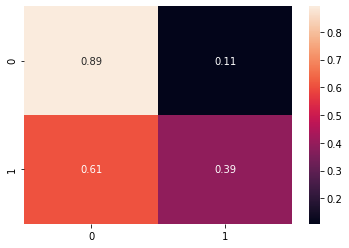

In [657]:
# Check confusion matrix again
cm = confusion_matrix(y_test, y_pred, normalize = 'true')
sns.heatmap(cm, annot = True)

In [ ]:
# get report
neighbors_scaled = classification_report(y_test, y_pred)

This model seems to do the best out of all the models at identifying true negatives, with a score of almost 0.9, however it is not very good at identifying true positives.

However, for business purposes, it may be that the most important thing is to know when the next day closing price will truly go down, rather than go up if you're risk adverse.

## Bonus: Make classification problem into a regression problem

In [664]:
# try simple linear regression model
import statsmodels.api as sm

# assign features and target for modeling
X = data[['30d', '7d', 'prc_30d', 'prc_7d', 'std_30d', 'volume', 'neu',
          'compound', 'prc_volume', '7d_binary', '30d_binary', 'open/close',
          'range', 'day_monday', 'day_thursday', 'day_tuesday', 'day_wednesday']]
# add constant
X = sm.add_constant(X)

y = data['1d_prc'].values.reshape(-1,1) # not sure why I have to reshape this?


# create training and test sets with 40% of data in the test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=2)

# scale just the training data set
scaler = MinMaxScaler(feature_range = (0,1))
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train),
                       columns = ['const','30d', '7d', 'prc_30d', 'prc_7d', 'std_30d', 'volume', 'neu',
                                  'compound', 'prc_volume', '7d_binary', '30d_binary', 'open/close',
                                  'range', 'day_monday', 'day_thursday', 'day_tuesday', 'day_wednesday'])
X_test = pd.DataFrame(scaler.transform(X_test),
                       columns = ['const','30d', '7d', 'prc_30d', 'prc_7d', 'std_30d', 'volume', 'neu',
                                  'compound', 'prc_volume', '7d_binary', '30d_binary', 'open/close',
                                  'range', 'day_monday', 'day_thursday', 'day_tuesday', 'day_wednesday'])

# fit an OLS model using statsmodels
results = sm.OLS(y_train,X_train).fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.226
Model:                            OLS   Adj. R-squared (uncentered):              0.225
Method:                 Least Squares   F-statistic:                              184.2
Date:                Mon, 14 Sep 2020   Prob (F-statistic):                        0.00
Time:                        17:11:32   Log-Likelihood:                          3976.8
No. Observations:               10731   AIC:                                     -7920.
Df Residuals:                   10714   BIC:                                     -7796.
Df Model:                          17                                                  
Covariance Type:            nonrobust                                                  
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

/Users/kacikus/opt/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1827: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
/Users/kacikus/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1362: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/Users/kacikus/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/Users/kacikus/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/Users/kacikus/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


From the OLS summary, it appears several features aren't statistically significant. These are: volume, neu, compund, and the days of the week. Let's try dropping those features.

In [687]:
# assign features and target for modeling
X = data[['30d', '7d', 'prc_30d', 'std_30d','prc_volume', 
          '7d_binary', '30d_binary', 'open/close','range']]
# add constant
X = sm.add_constant(X)

y = data['1d_prc'].values.reshape(-1,1) # not sure why I have to reshape this?


# create training and test sets with 40% of data in the test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=4)

# scale just the training data set
scaler = MinMaxScaler(feature_range = (0,1))
X_train = pd.DataFrame(scaler.fit_transform(X_train), 
                      columns = ['const','30d', '7d', 'prc_30d', 'std_30d','prc_volume', 
                                 '7d_binary', '30d_binary', 'open/close','range'])

# fit an OLS model using statsmodels
results = sm.OLS(y_train,X_train, random_state = 3).fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.230
Model:                            OLS   Adj. R-squared (uncentered):              0.229
Method:                 Least Squares   F-statistic:                              415.3
Date:                Mon, 14 Sep 2020   Prob (F-statistic):                        0.00
Time:                        17:25:44   Log-Likelihood:                          4599.9
No. Observations:               12520   AIC:                                     -9182.
Df Residuals:                   12511   BIC:                                     -9115.
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

/Users/kacikus/opt/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1827: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
/Users/kacikus/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1362: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/Users/kacikus/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/Users/kacikus/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/Users/kacikus/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


Dropping those features did not seem to improve the R^2 of the model. 

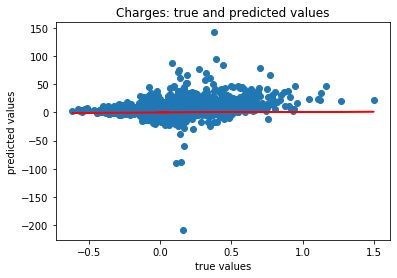

Mean absolute error of the prediction is: 5.339043550356465
Mean squared error of the prediction is: [ 41.58212677 345.65596314   3.07655399 ...  15.11940635   0.49678625
  45.54652977]
Root mean squared error of the prediction is: [ 6.44842049 18.59182517  1.75401083 ...  3.88836808  0.70483065
  6.74881692]


/Users/kacikus/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  


Mean absolute percentage error of the prediction is: inf


In [671]:
# let's plot the true next day % increase/decrease vs the predicted values
y_preds = results.predict(X_test).values

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

There appears to be a major ourlier in the predicted values for some reason... Also, true values range from <-0.5 to >1.25..... maybe limit the range that values can be?

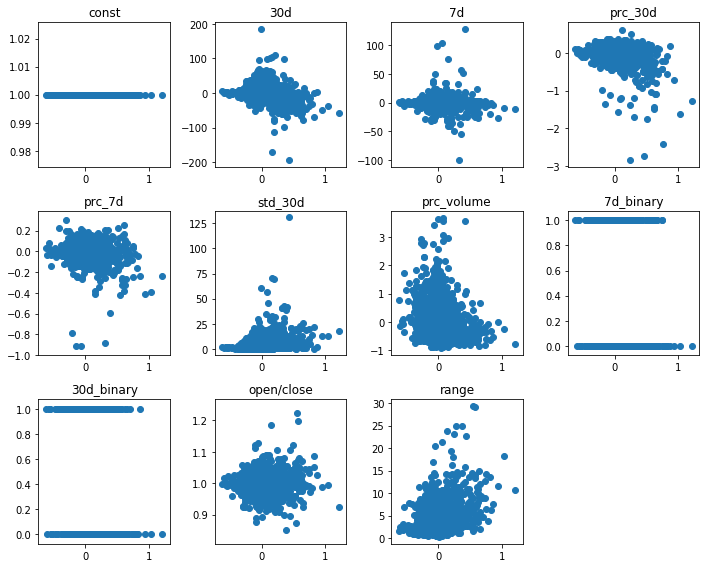

In [566]:
plt.figure(figsize= (10,8))
i = 1
for var in X_test:
    plt.subplot(3,4,i)
    plt.scatter(y_test, X_test[var])
    plt.title(var)
    i+=1
    
plt.tight_layout()

In [686]:
to_drop = pd.Series(y_preds).loc[(y_preds > 75) | (y_preds < -50)].index.to_list() # the indices of outlier values 
X_test.iloc[to_drop] # drop these outliers
X_test.drop(to_drop, inplace = True, axis = 0)
X_test.info()

[44, 605, 899, 901, 1235, 1618, 1769, 2280, 2635, 4052, 5347]


KeyError: '[  44  605  901 1618 1769 2635 4052 5347] not found in axis'

In [ ]:
# try scikitlearn model for deep learning